# Neurons example, pt. 1
## Generate some data

In [1]:
from bayes_window import models, fake_spikes_explore, BayesWindow
from bayes_window.generative_models import generate_fake_spikes
import numpy as np
import altair as alt
alt.renderers.enable('altair_saver', fmts=['png']);

In [2]:

df, df_monster, index_cols, firing_rates = generate_fake_spikes(n_trials=20,
                                                                n_neurons=6,
                                                                n_mice=3,
                                                                dur=5,
                                                               mouse_response_slope=40,
                                                               overall_stim_response_strength=5)


## Exploratory plot without any fitting

Three mice, five neurons each. Mouse #0/neuron #4 has the least effect, mouse #2/neuron #0 the most

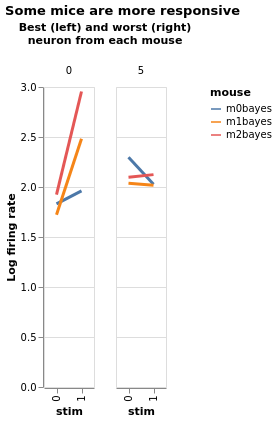

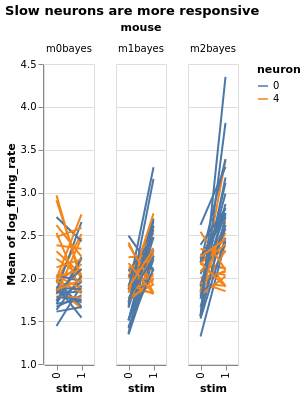

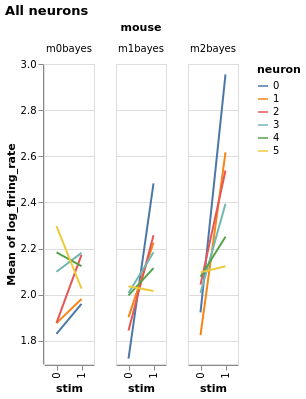

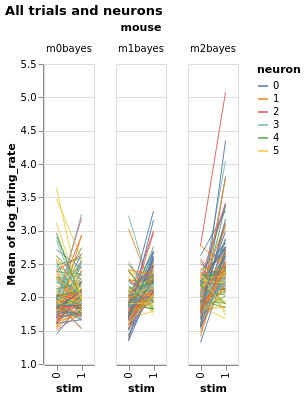

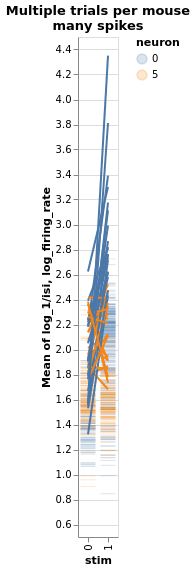

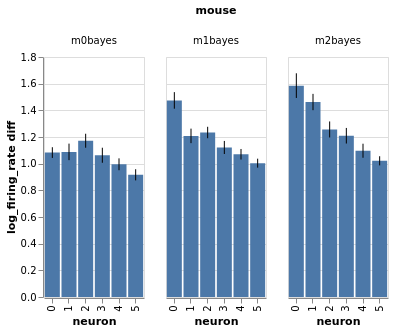

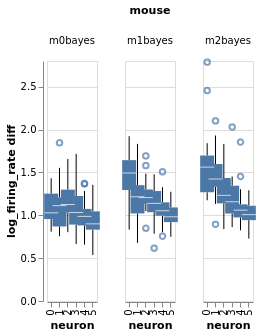

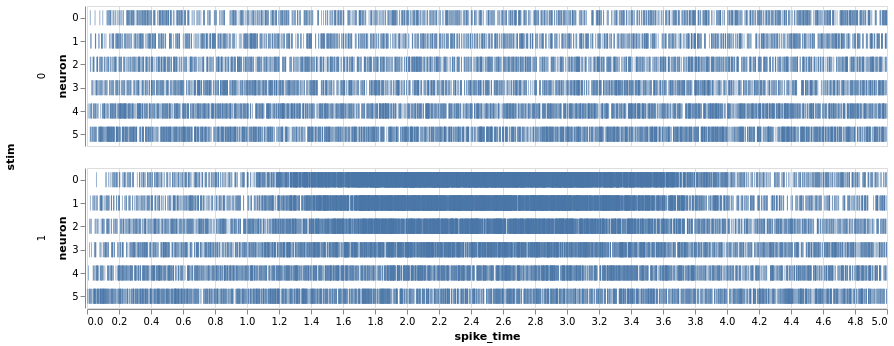

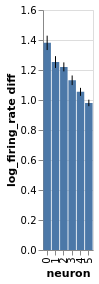

In [3]:

charts=fake_spikes_explore(df,df_monster,index_cols)
[chart.display() for chart in charts];
#fig_mice, fig_select, fig_neurons, fig_trials, fig_isi + fig_overlay, bar, box, fig_raster, bar_combined

## Estimate with neuron as condition

### ISI

In [4]:
df['log_isi']=np.log10(df['isi'])

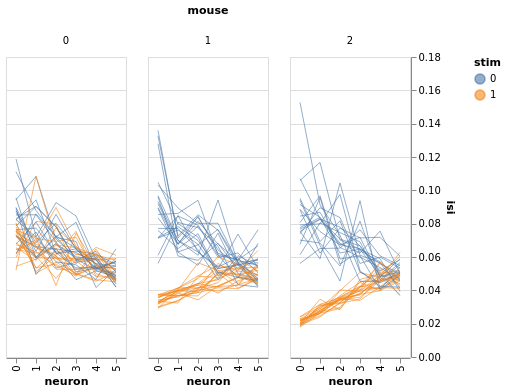

In [5]:
alt.data_transformers.disable_max_rows()
bw = BayesWindow(df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',color='stim',detail='i_trial',add_box=False).facet(column='mouse',)

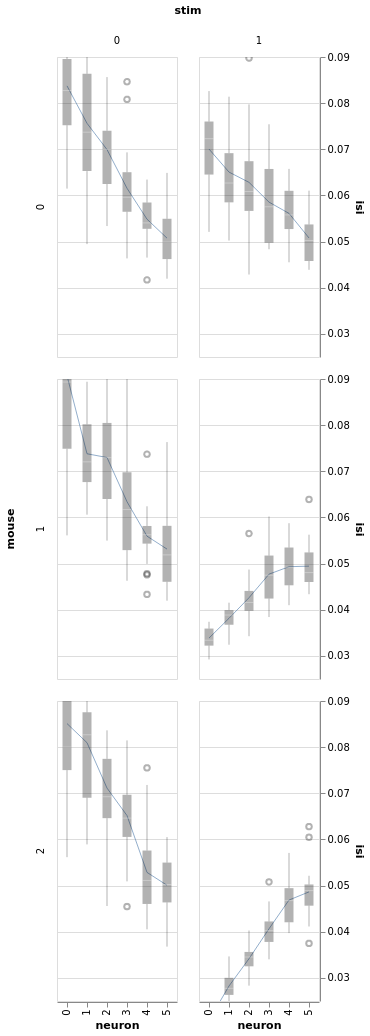

In [6]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',add_box=True).facet(row='mouse',column='stim')

## Vanilla regression

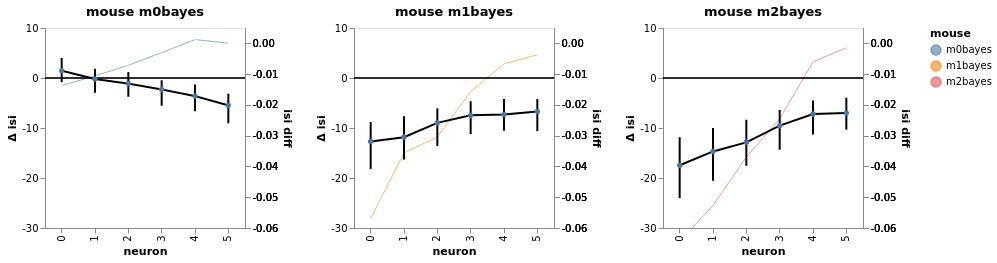

In [24]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='normal',
              robust_slopes=False,
              add_group_slope=False, 
              add_group_intercept=True, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True, add_box=True)


bw.facet(column='mouse',width=200,height=200).display()

## GLM 
($y\sim Gamma(\theta)$)

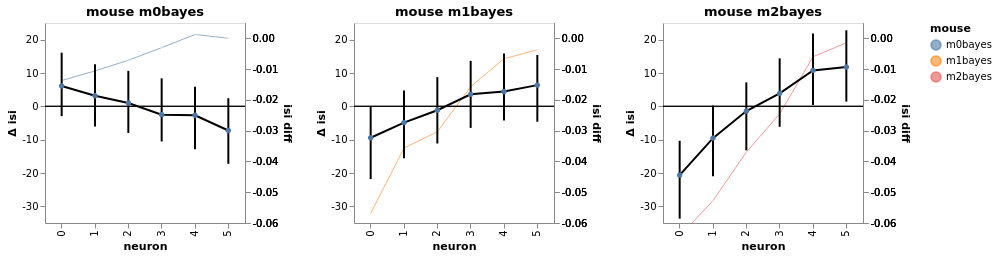

In [35]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_slope=True, 
              add_group_intercept=True, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True, add_box=True)


bw.facet(column='mouse',width=200,height=200).display()

In [5]:
import altair as alt
slopes=bw.trace.posterior['slope_per_group'].mean(['chain','draw']).to_dataframe().reset_index()
chart_slopes=alt.Chart(slopes).mark_bar().encode(
    x=alt.X('mouse_:O',title='Mouse'),
    y=alt.Y('slope_per_group', title='Slope')
)
chart_slopes

alt.Chart(...)

In [42]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse',)
#bw.fit_anova()
bw.fit_lme()

Using formula firing_rate ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                               Coef. Std.Err.       z  P>|z|     [0.025  \
Intercept                    240.552  296.280   0.812  0.417   -340.146   
1 | mouse                     79.461  153.340   0.518  0.604   -221.079   
stim | neuron_x_mouse__0    -166.484  500.546  -0.333  0.739  -1147.536   
stim | neuron_x_mouse__1    -146.256  500.546  -0.292  0.770  -1127.309   
stim | neuron_x_mouse__2    -142.650  500.546  -0.285  0.776  -1123.703   
stim | neuron_x_mouse__3    -121.426  500.546  -0.243

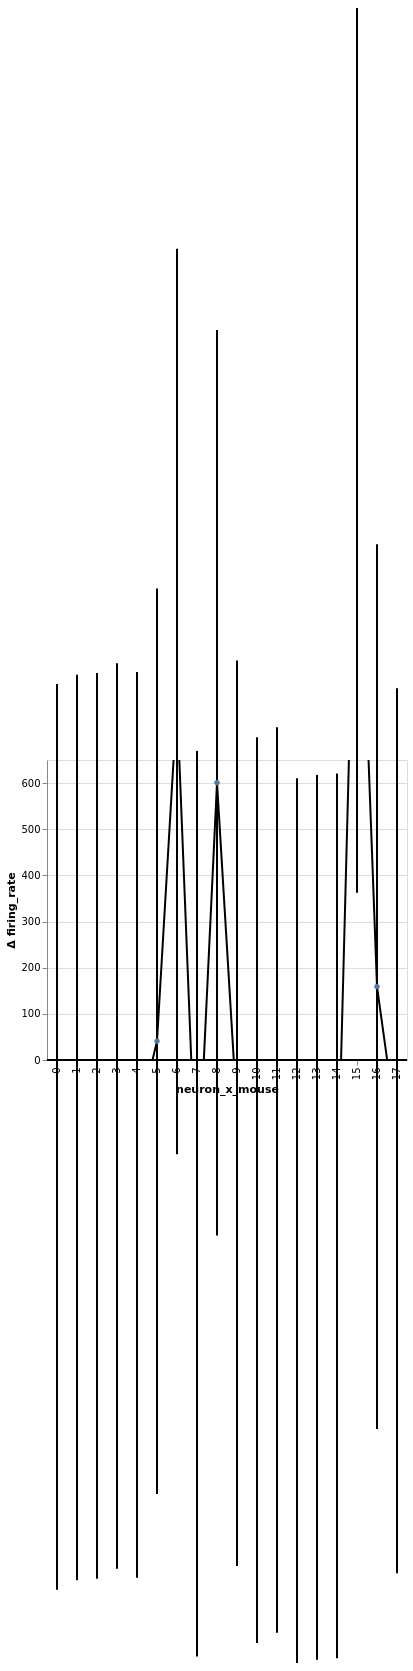

In [41]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O')

### Firing rate

In [8]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')
bw.fit_slopes(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=False,
              dist_y='student',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

alt.HConcatChart(...)

ANOVA may not be appropriate here: It considers every neuron. If we look hard enough, surely we'll find a responsive neuron or two out of hundreds?

In [5]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')

bw.fit_anova(formula='firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse');

firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse
                            sum_sq   df             F    PR(>F)
stim                -5.601501e-11  1.0 -2.323524e-15  1.000000
mouse                3.905859e+05  1.0  1.620165e+01  0.056538
stim:mouse           1.420670e+05  1.0  5.892995e+00  0.135934
neuron_x_mouse       3.305325e+04  1.0  1.371062e+00  0.362258
stim:neuron_x_mouse  7.737053e+04  1.0  3.209360e+00  0.215095
Residual             4.821556e+04  2.0           NaN       NaN


## Model quality

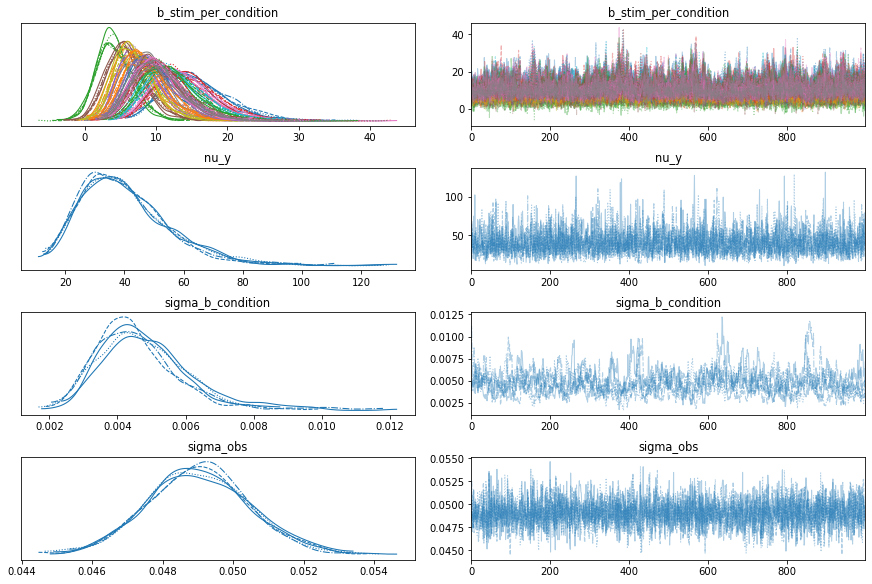

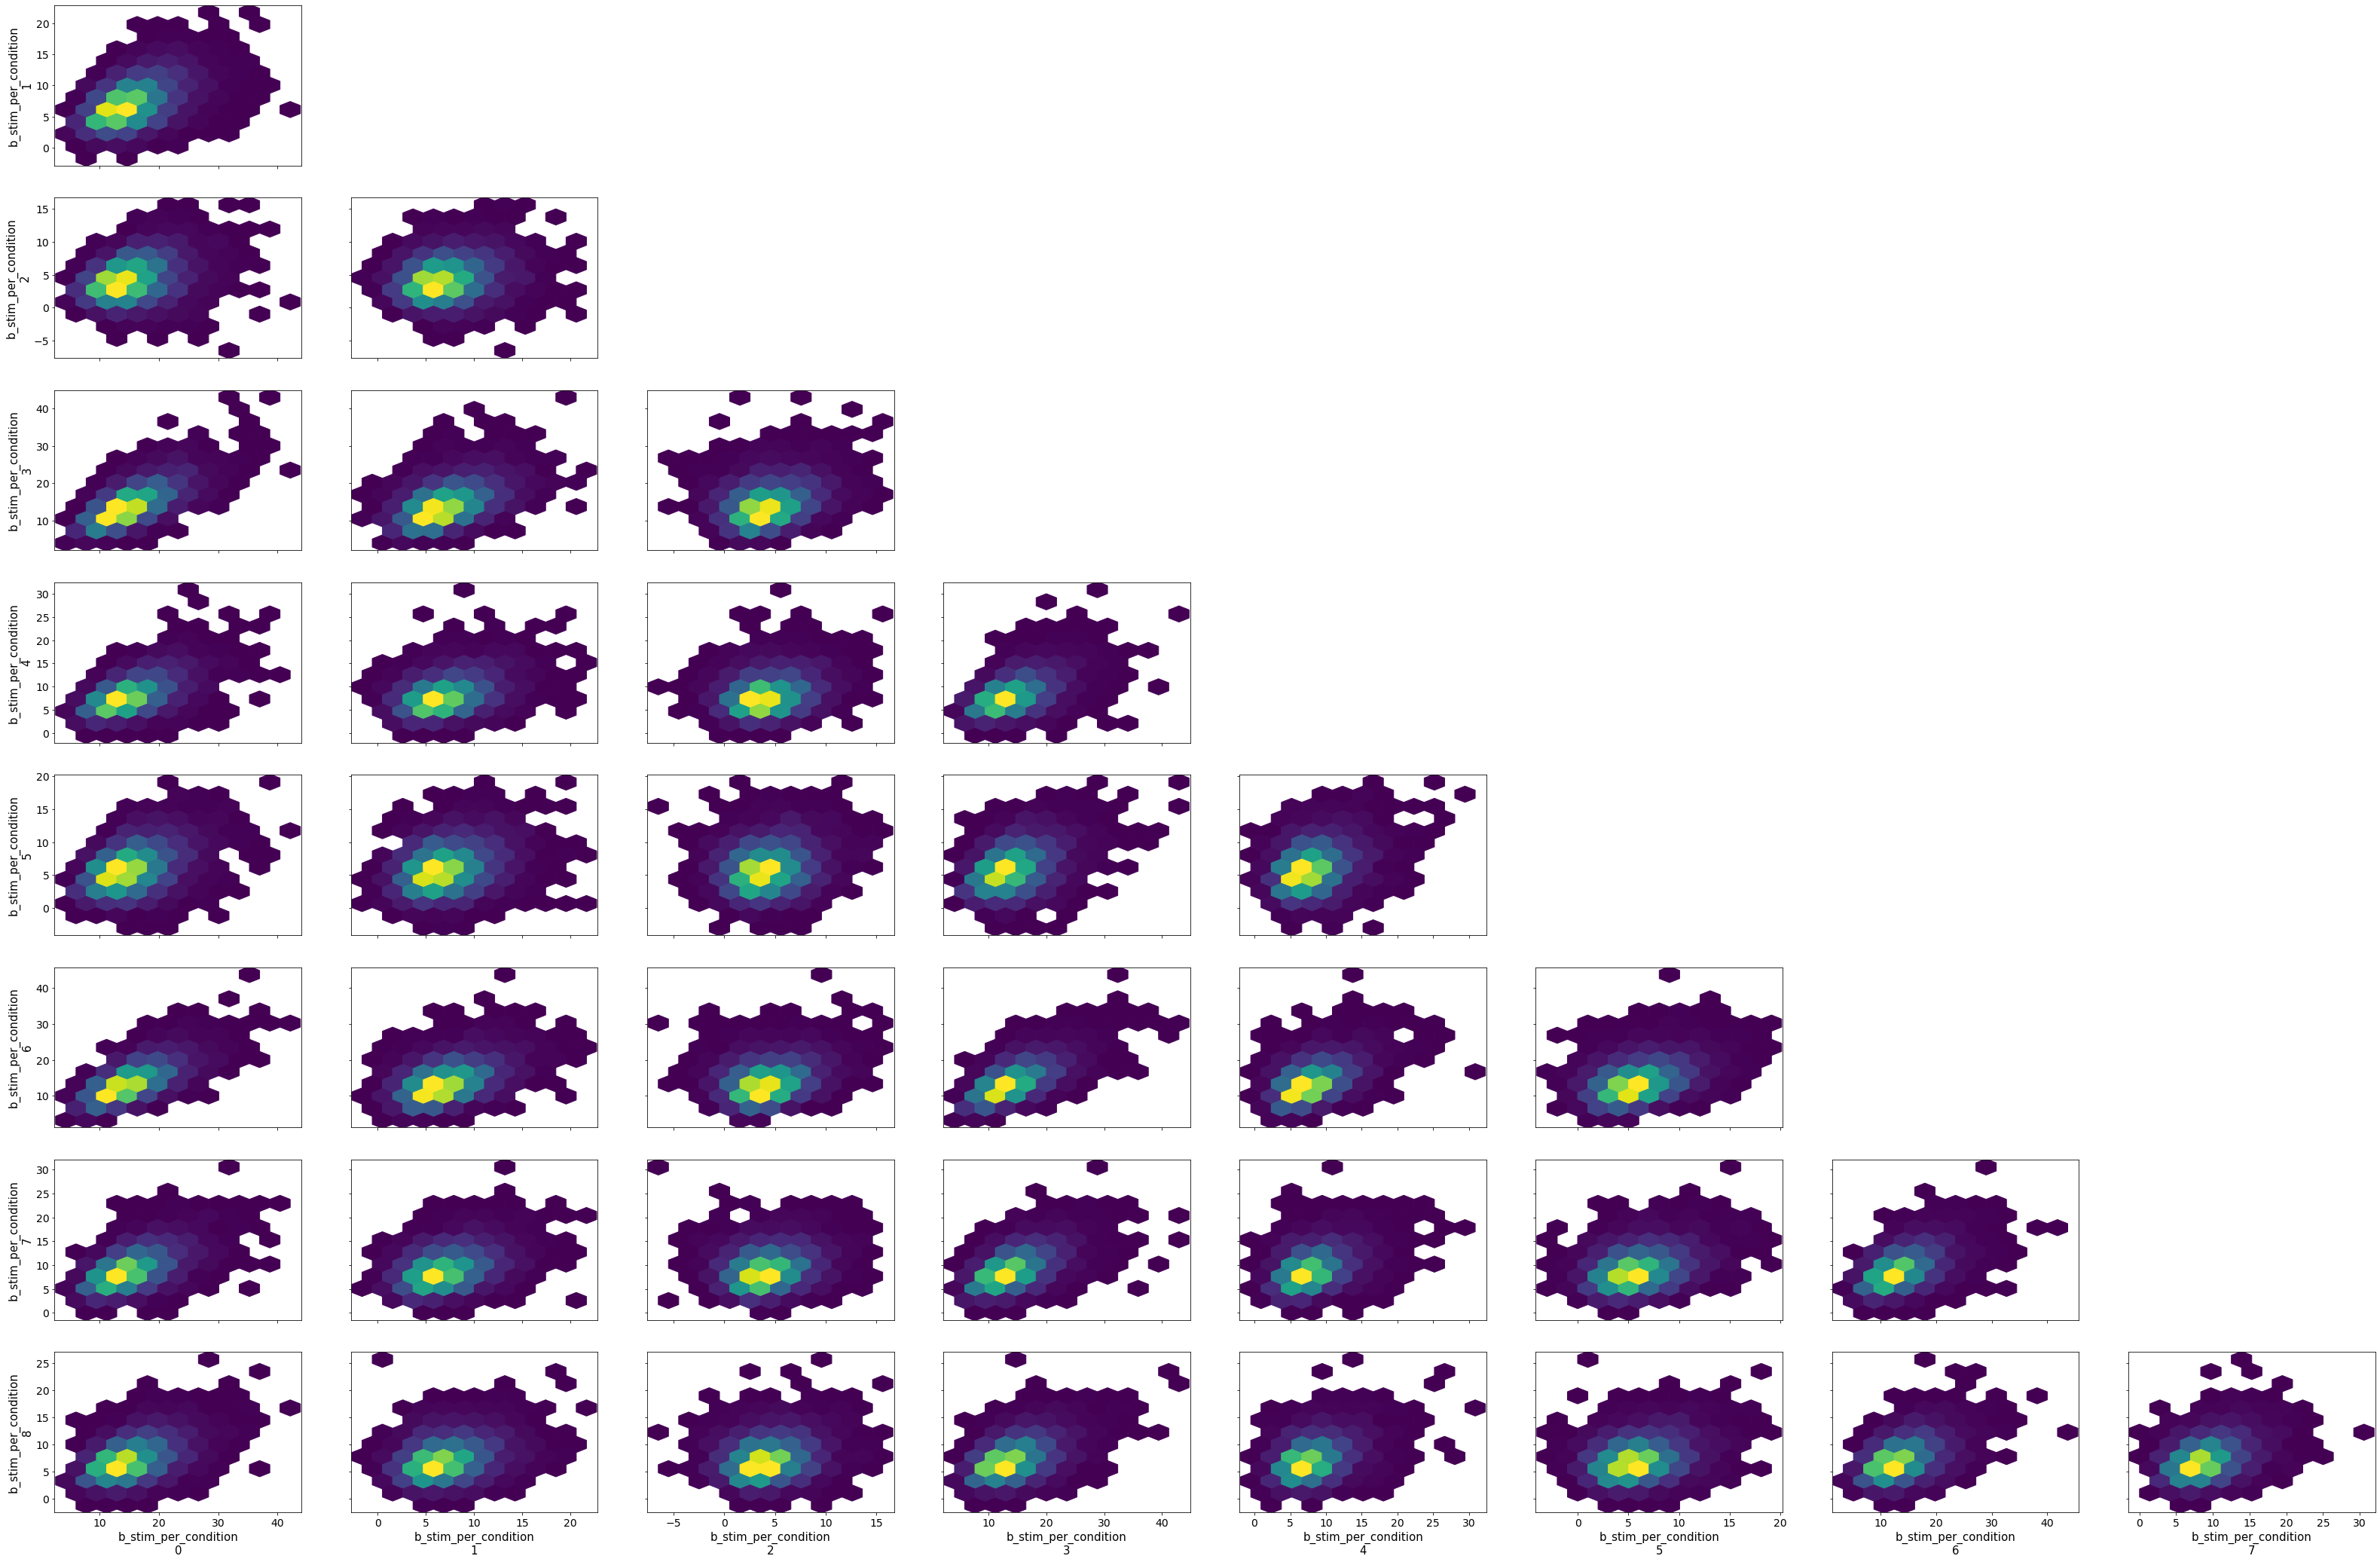

In [34]:
# Vanilla robust no interept or slope
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=False, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

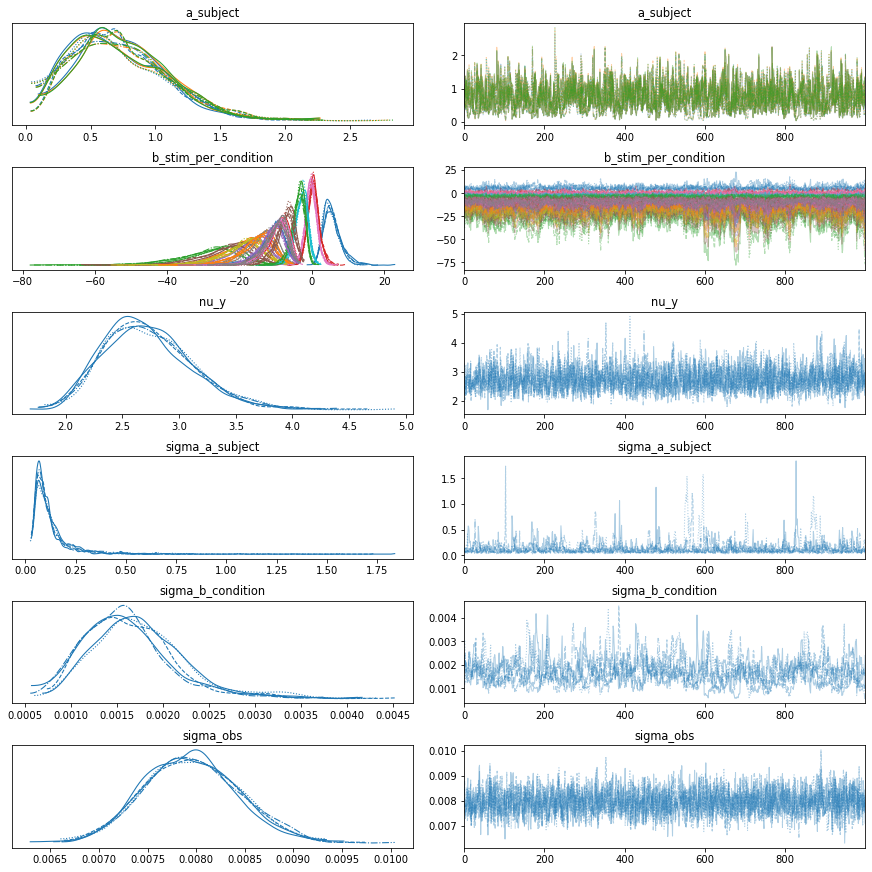

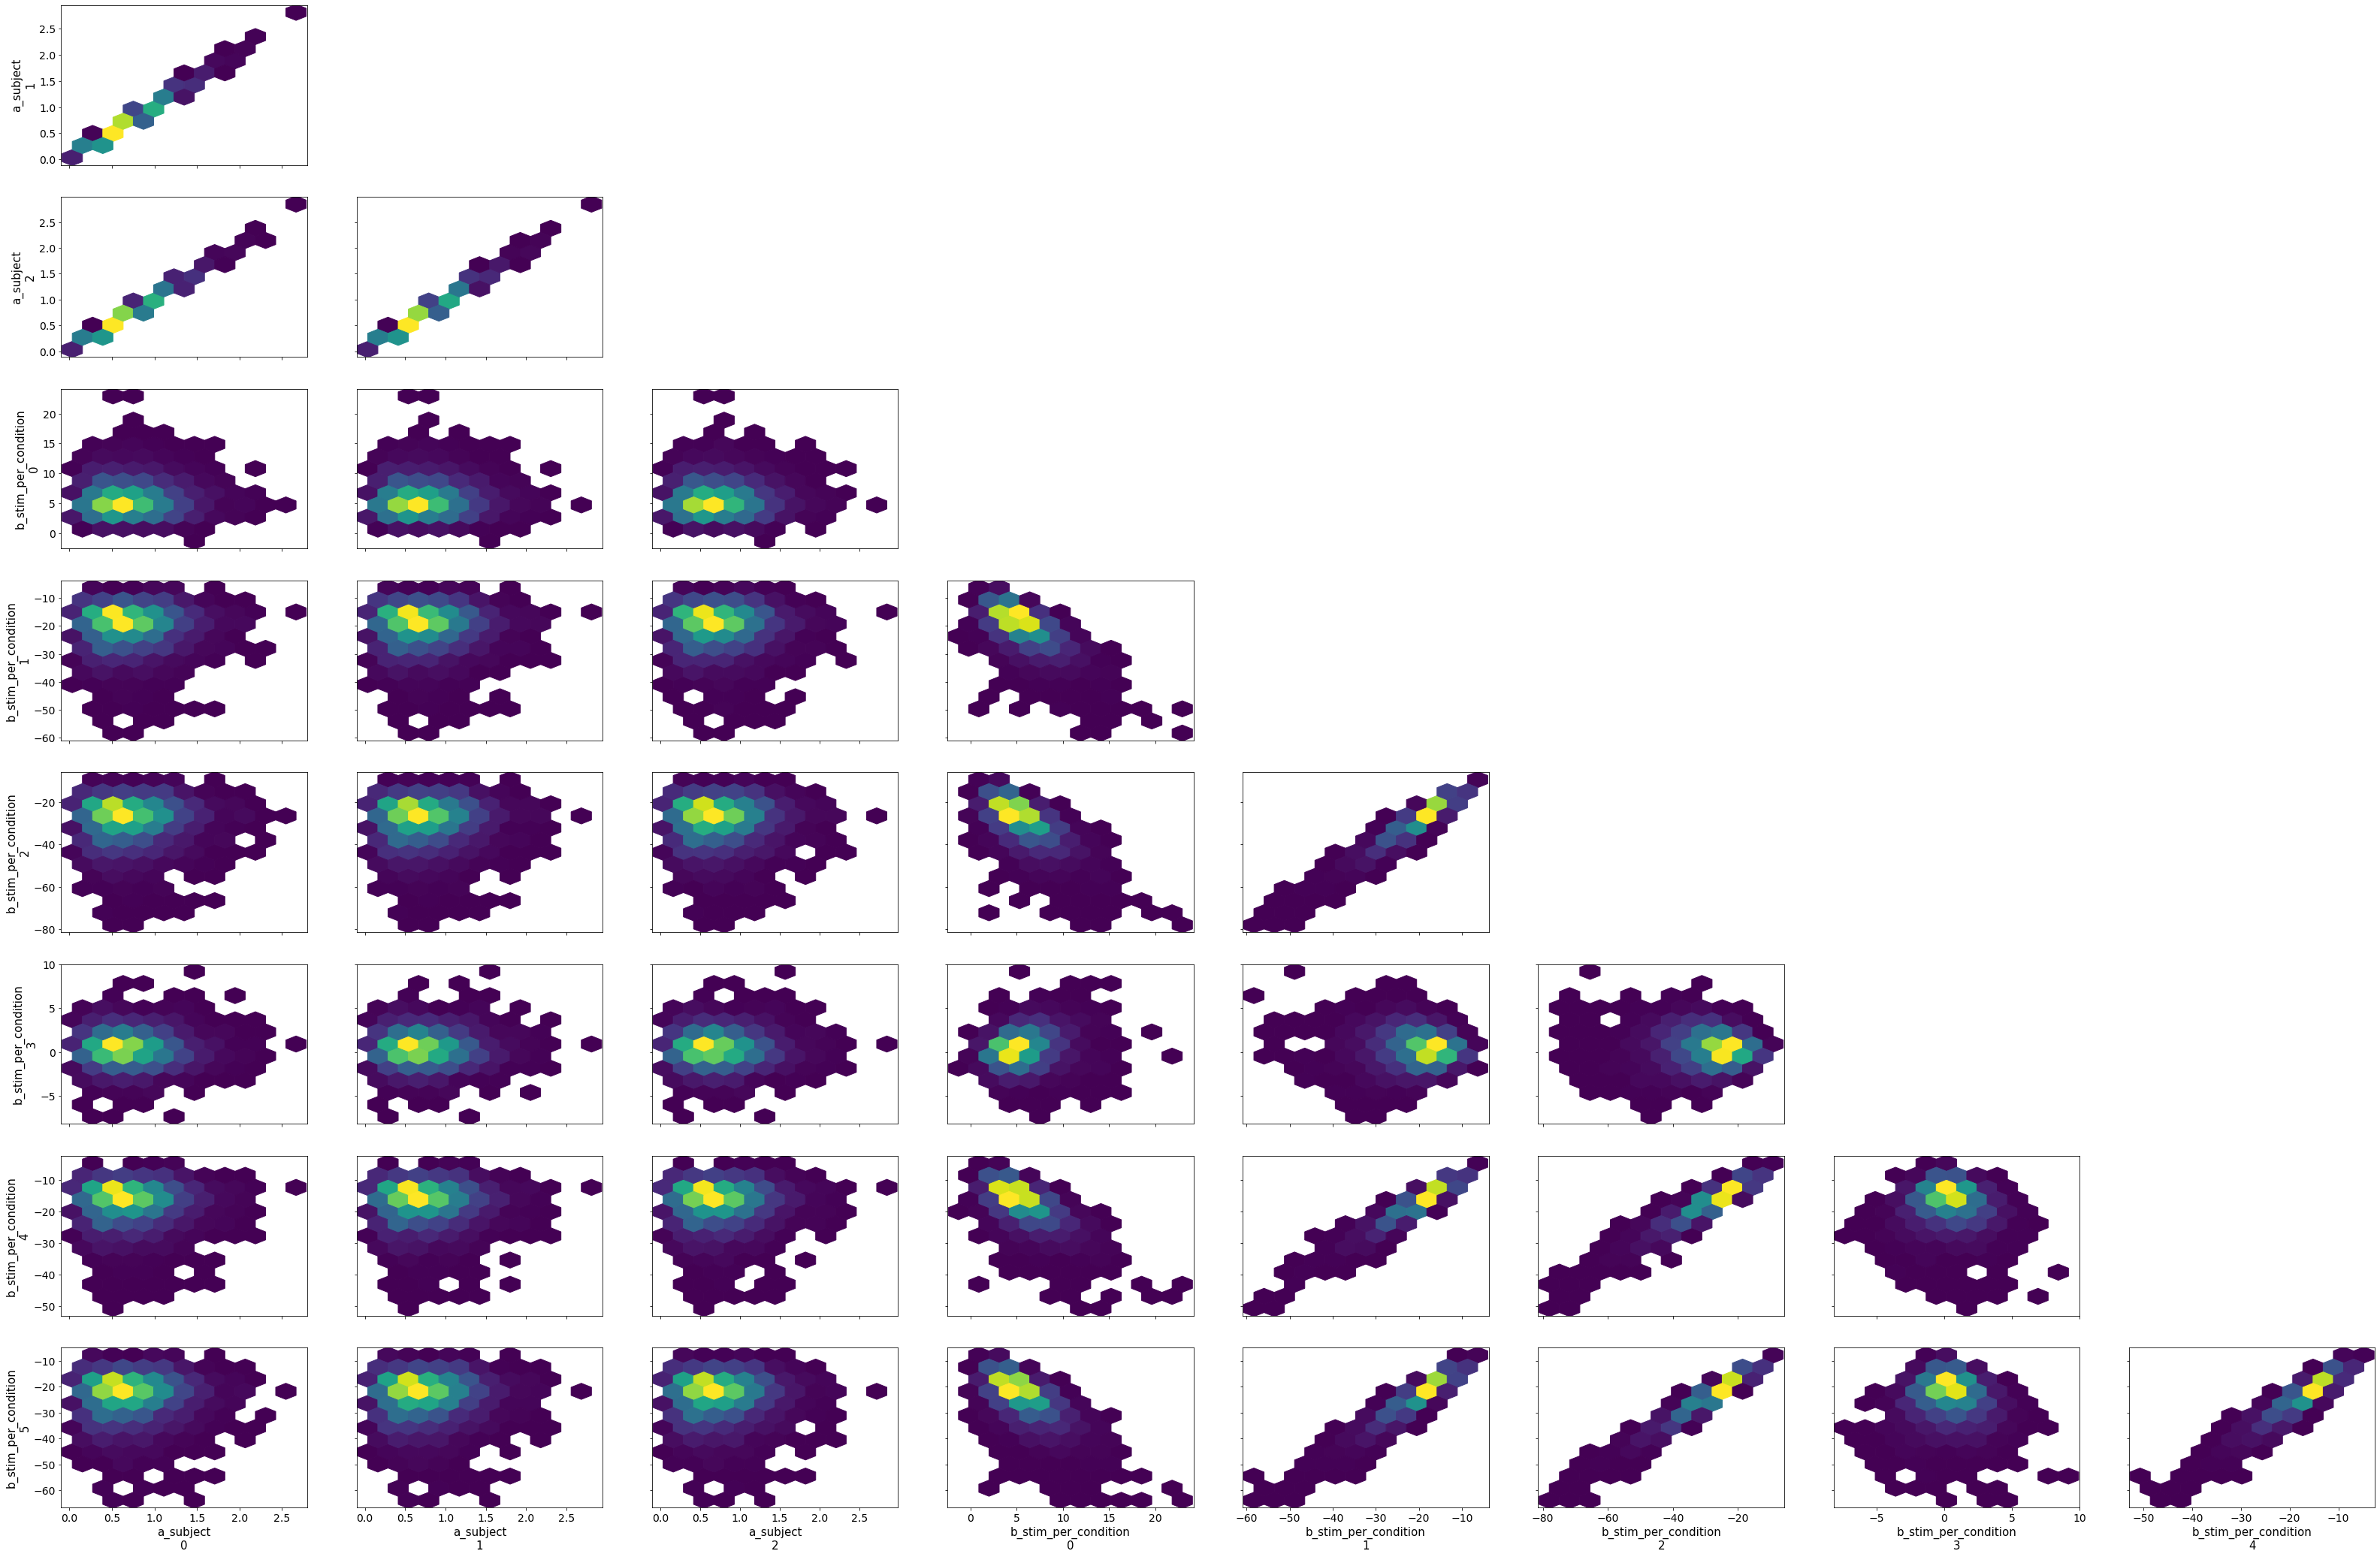

In [40]:
# Vanilla robust, intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=False, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 260


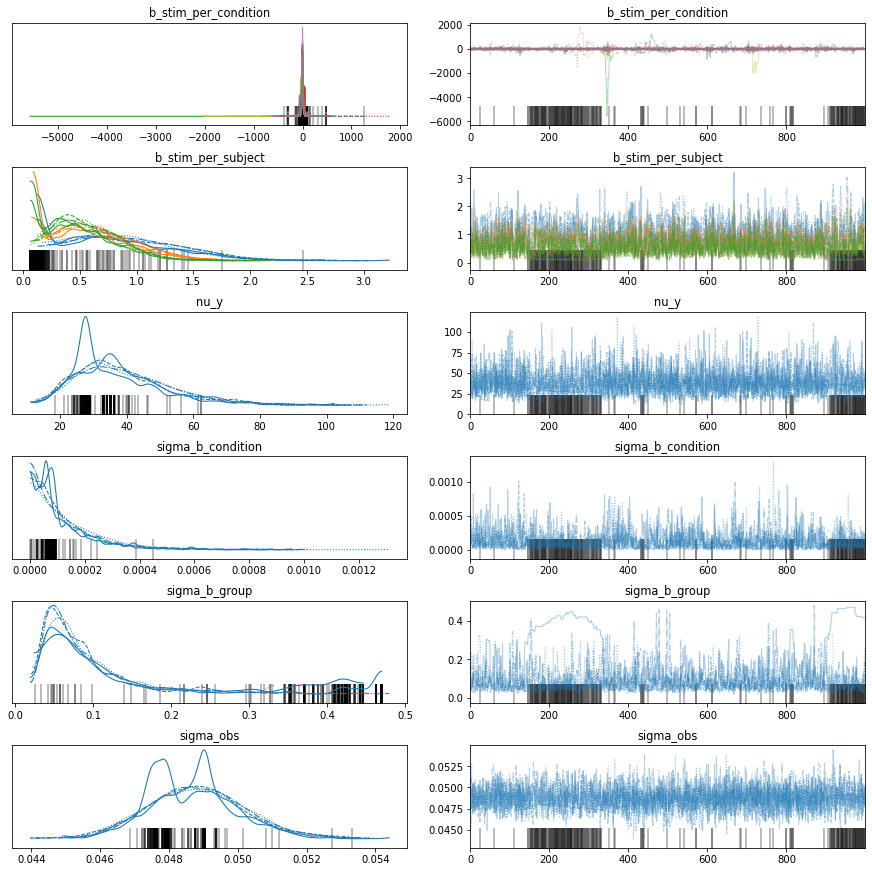

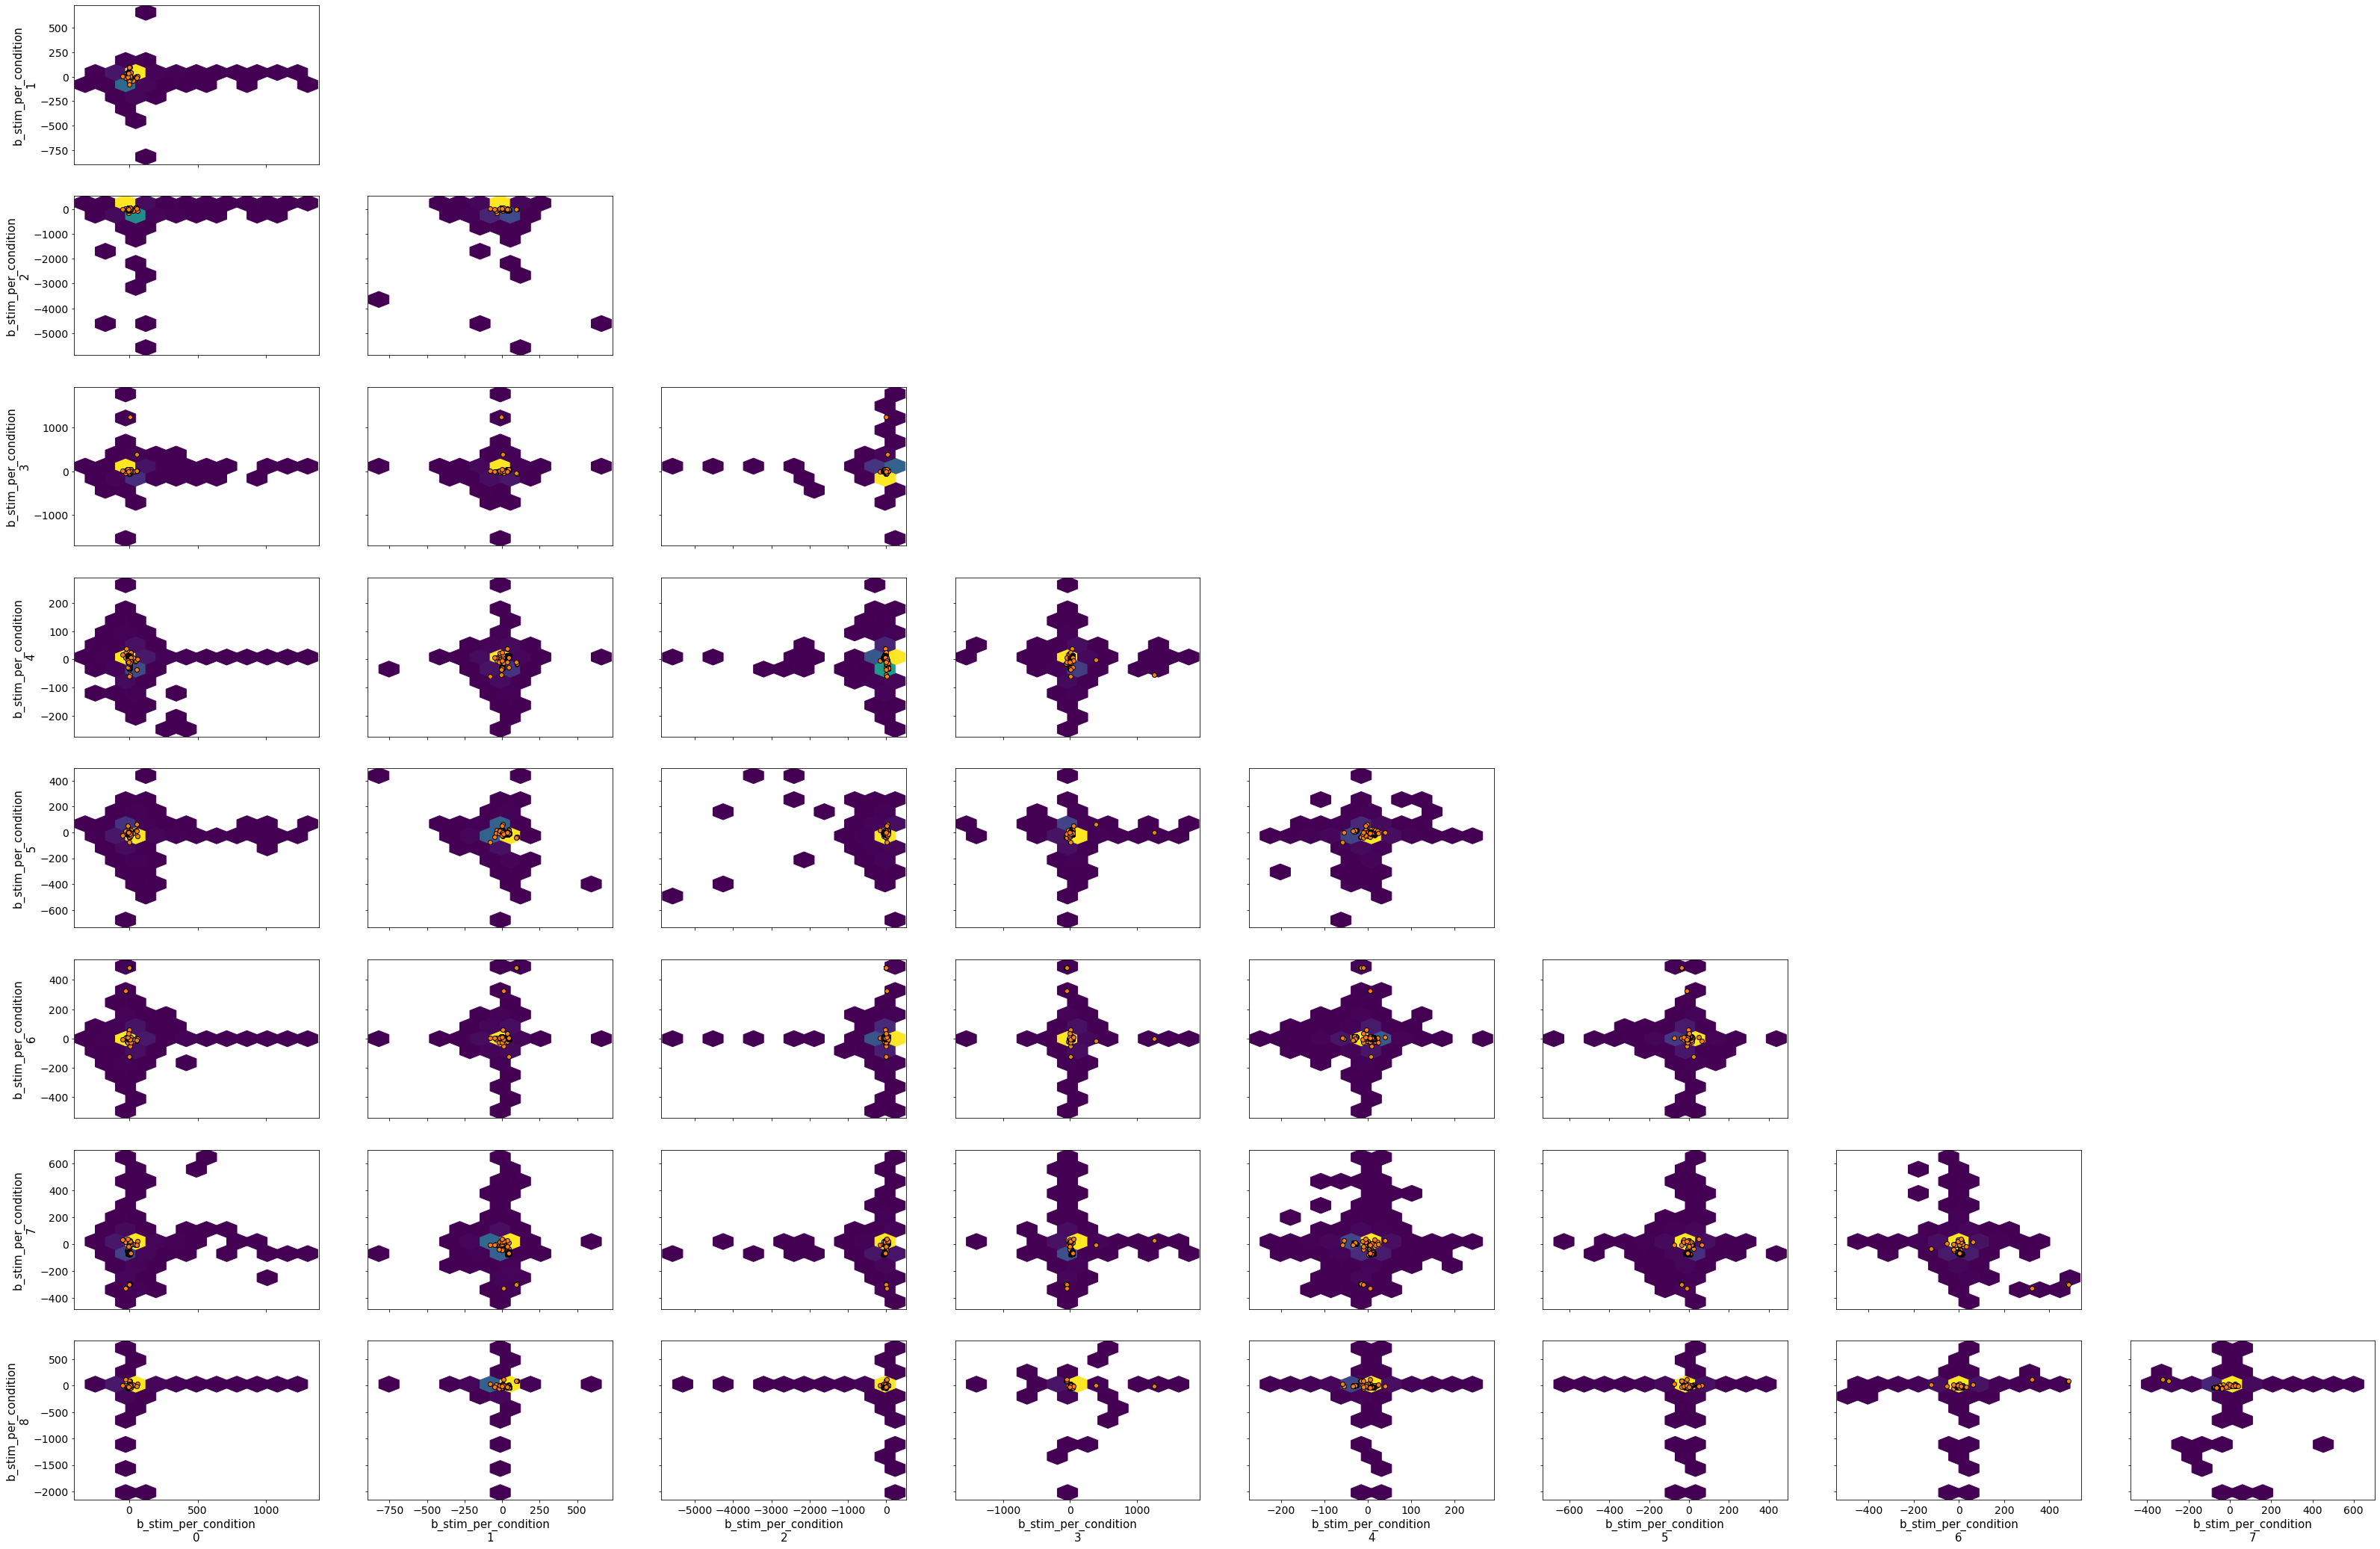

In [41]:
# Vanilla robust, slopes only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=True, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

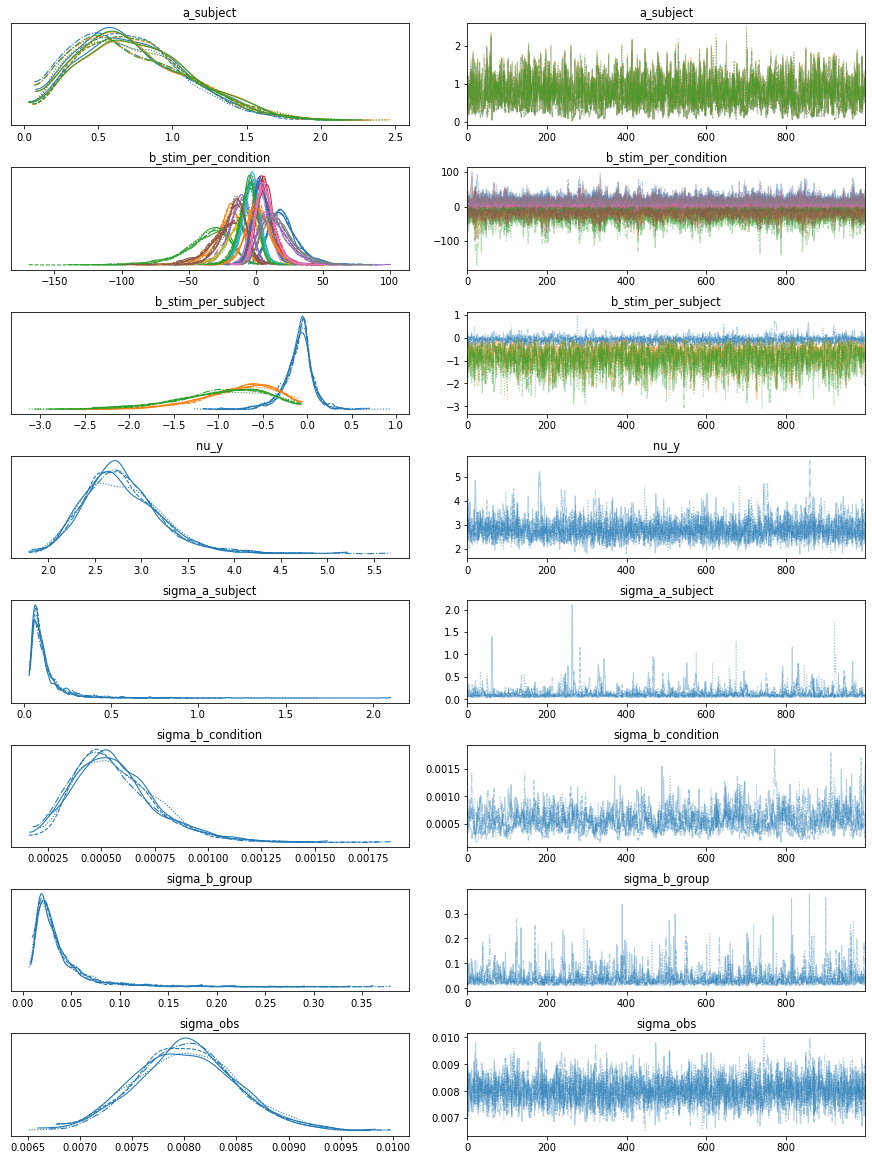

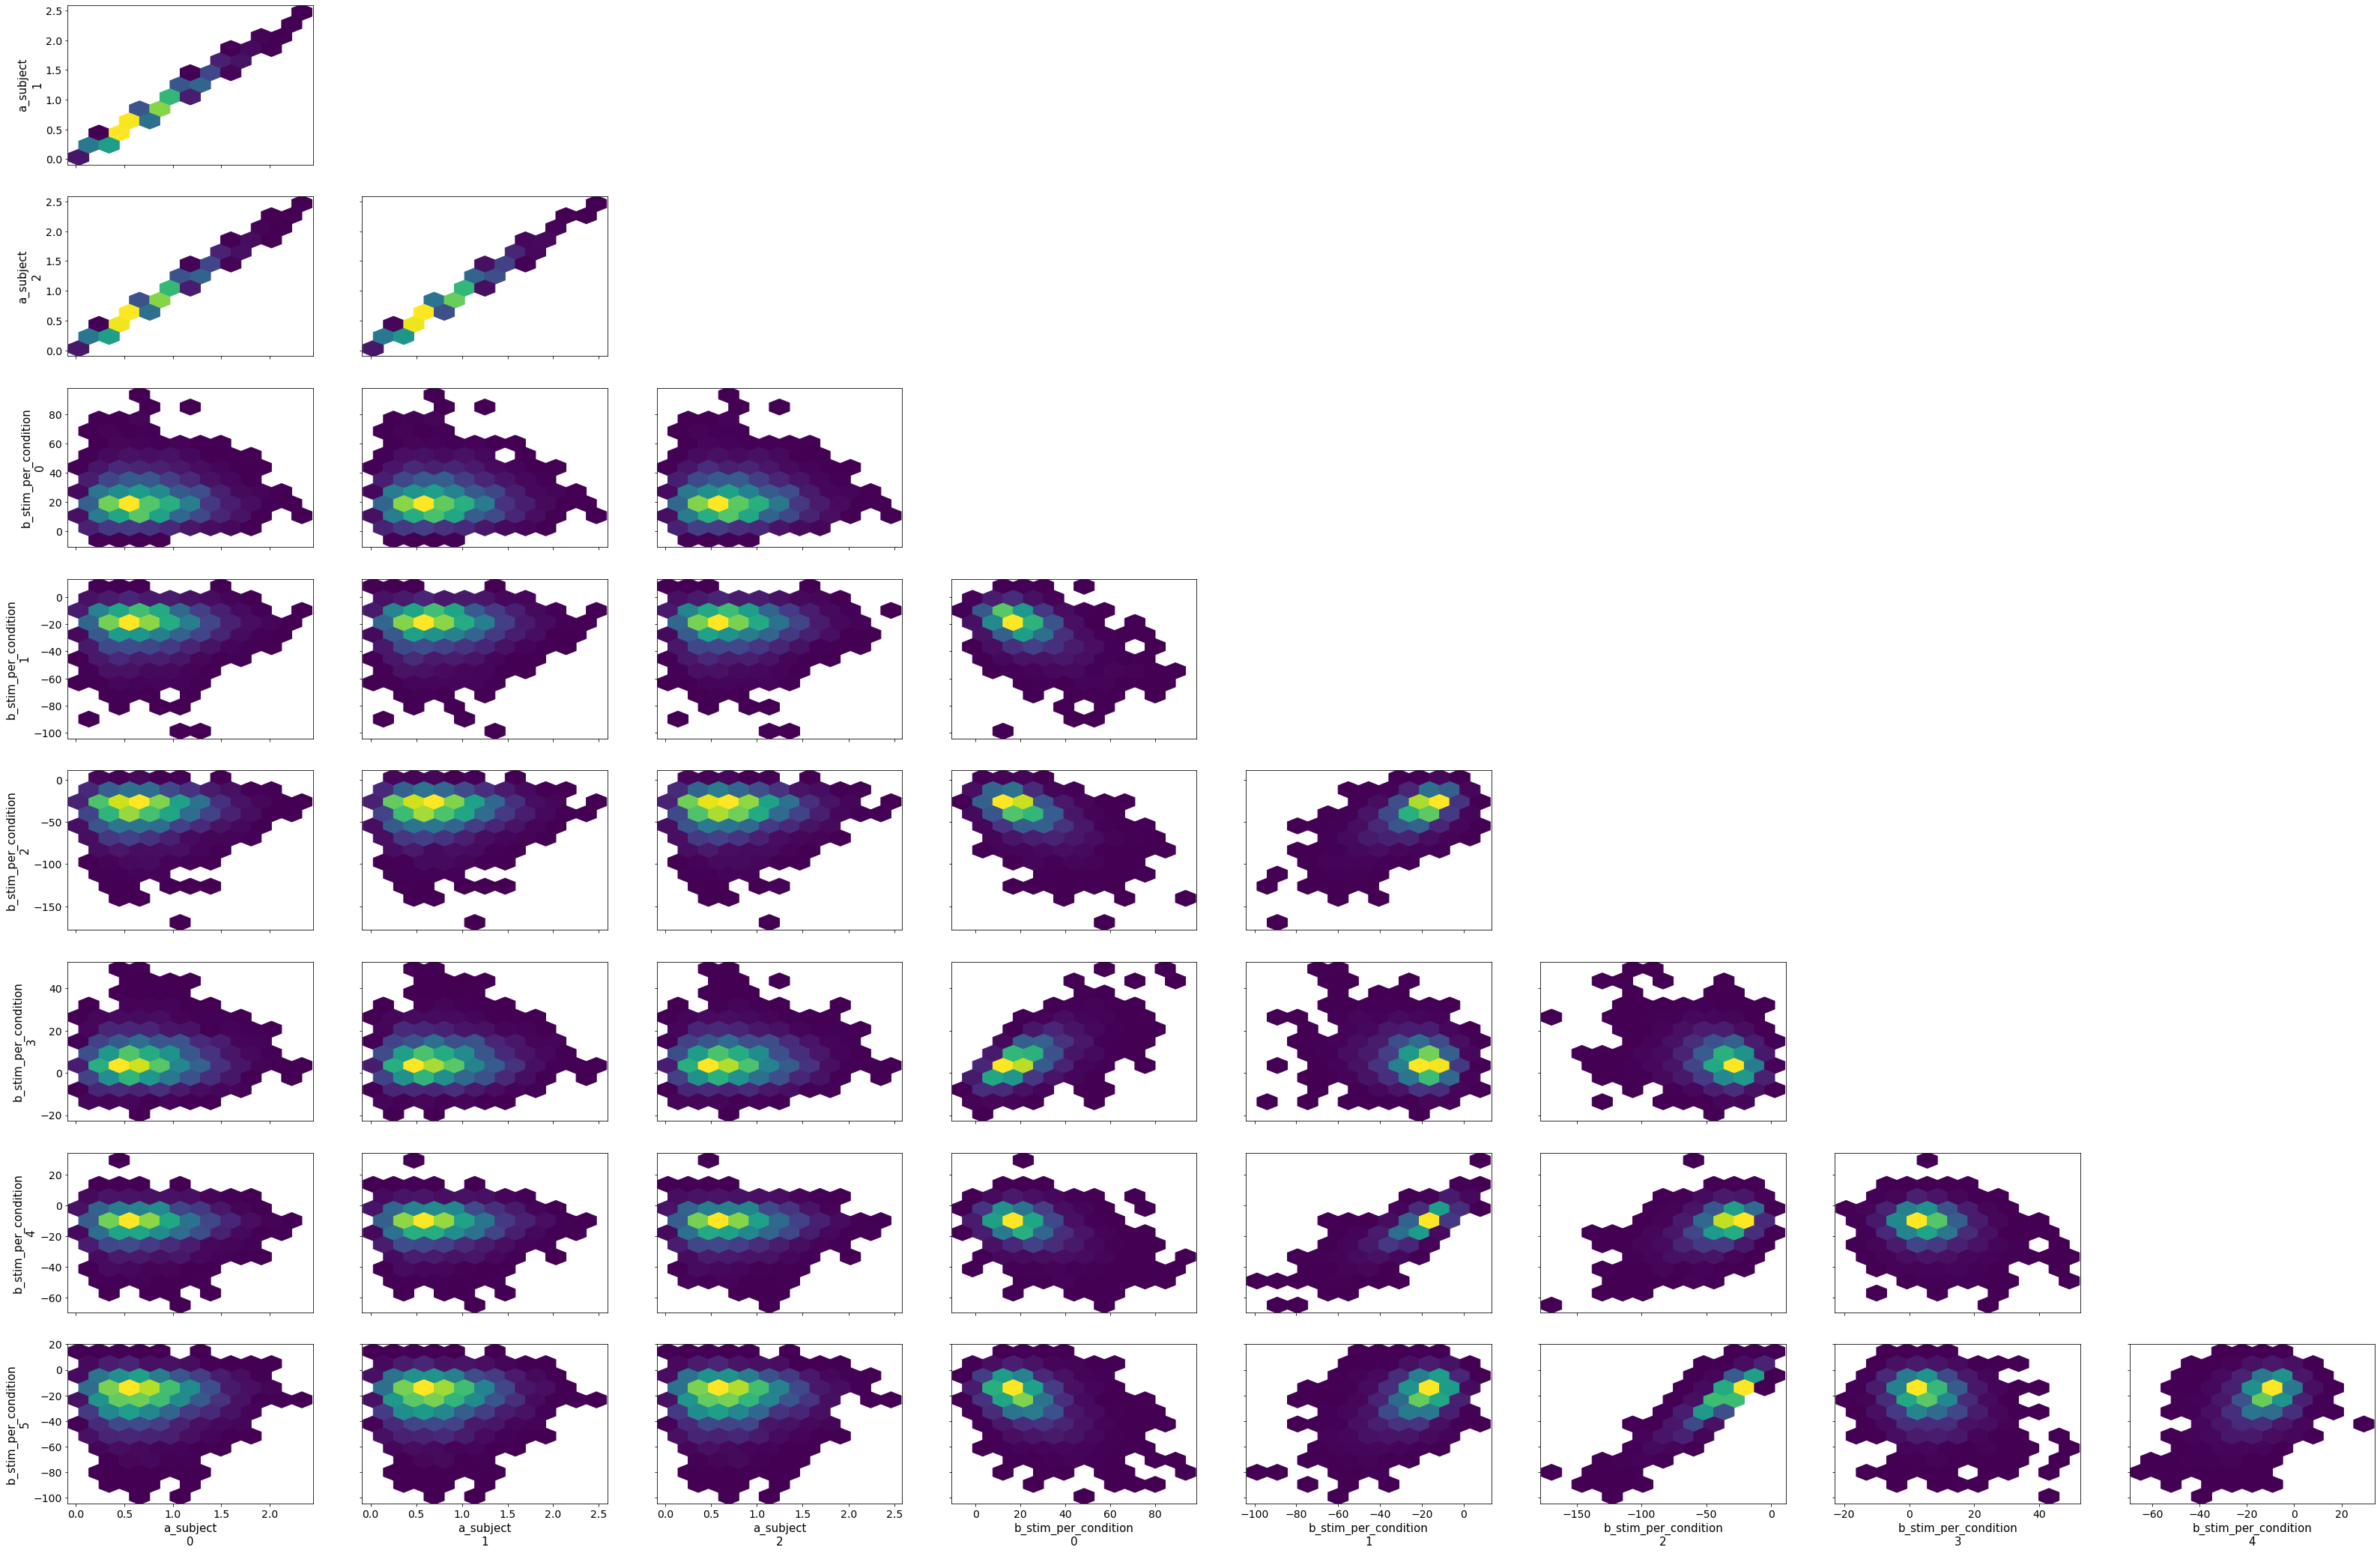

In [38]:
# Vanilla robust intercept and group
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=True, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 12


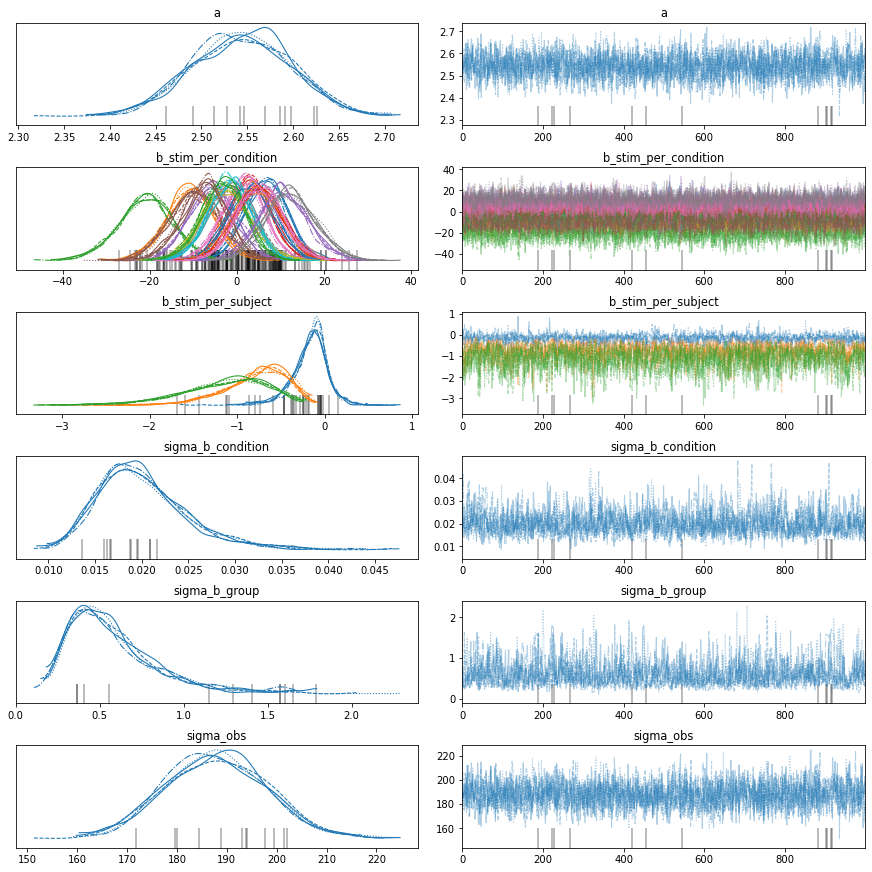

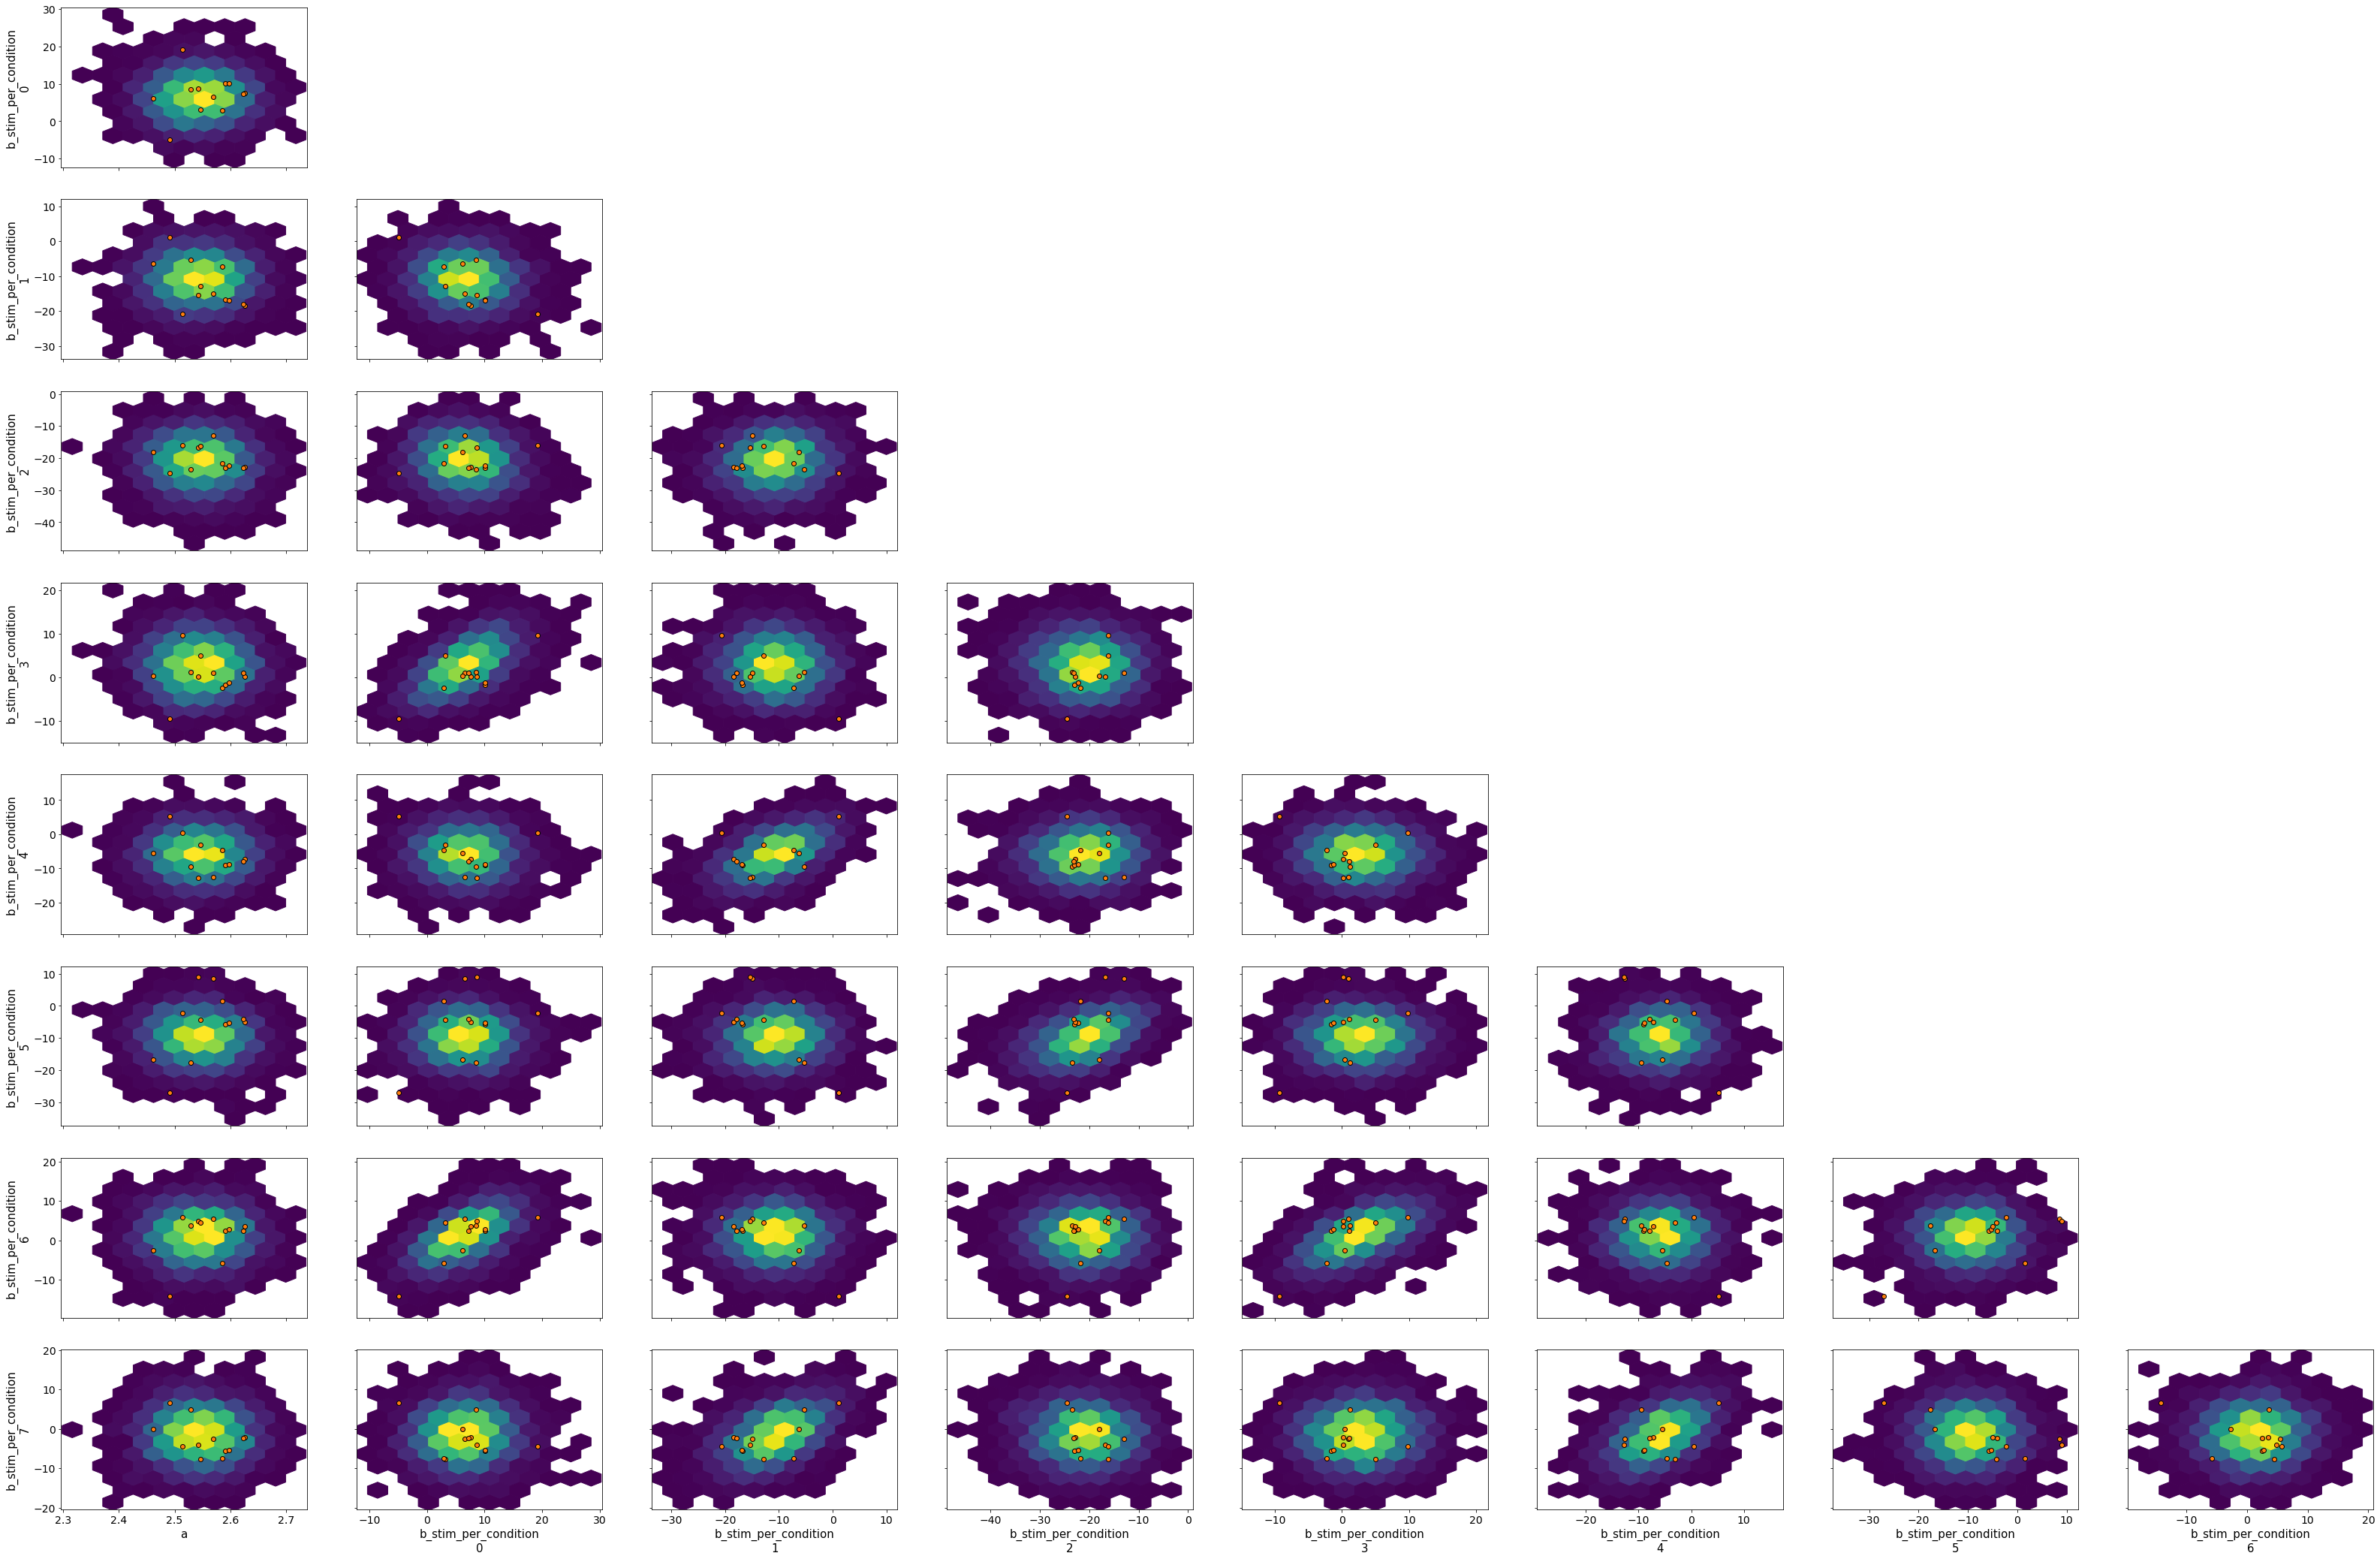

In [48]:
# Gamma GLM slope only
reload(models)
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=False,
              add_group_slope=True, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

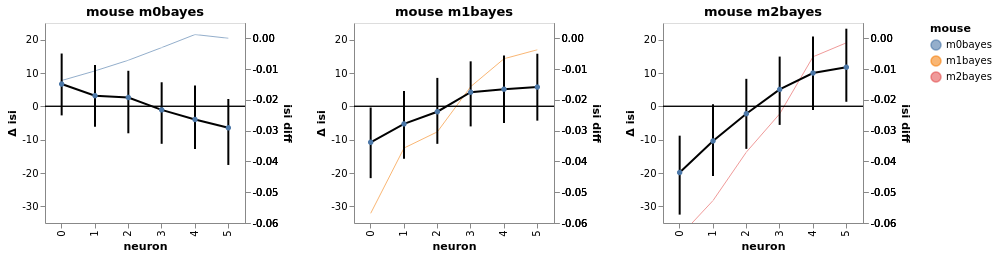

In [49]:
bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

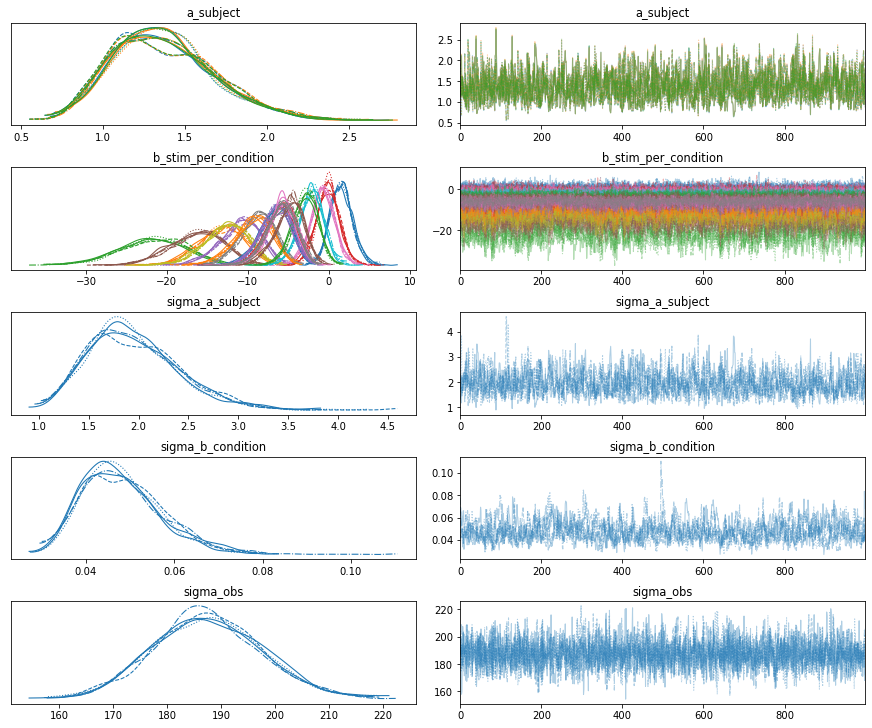

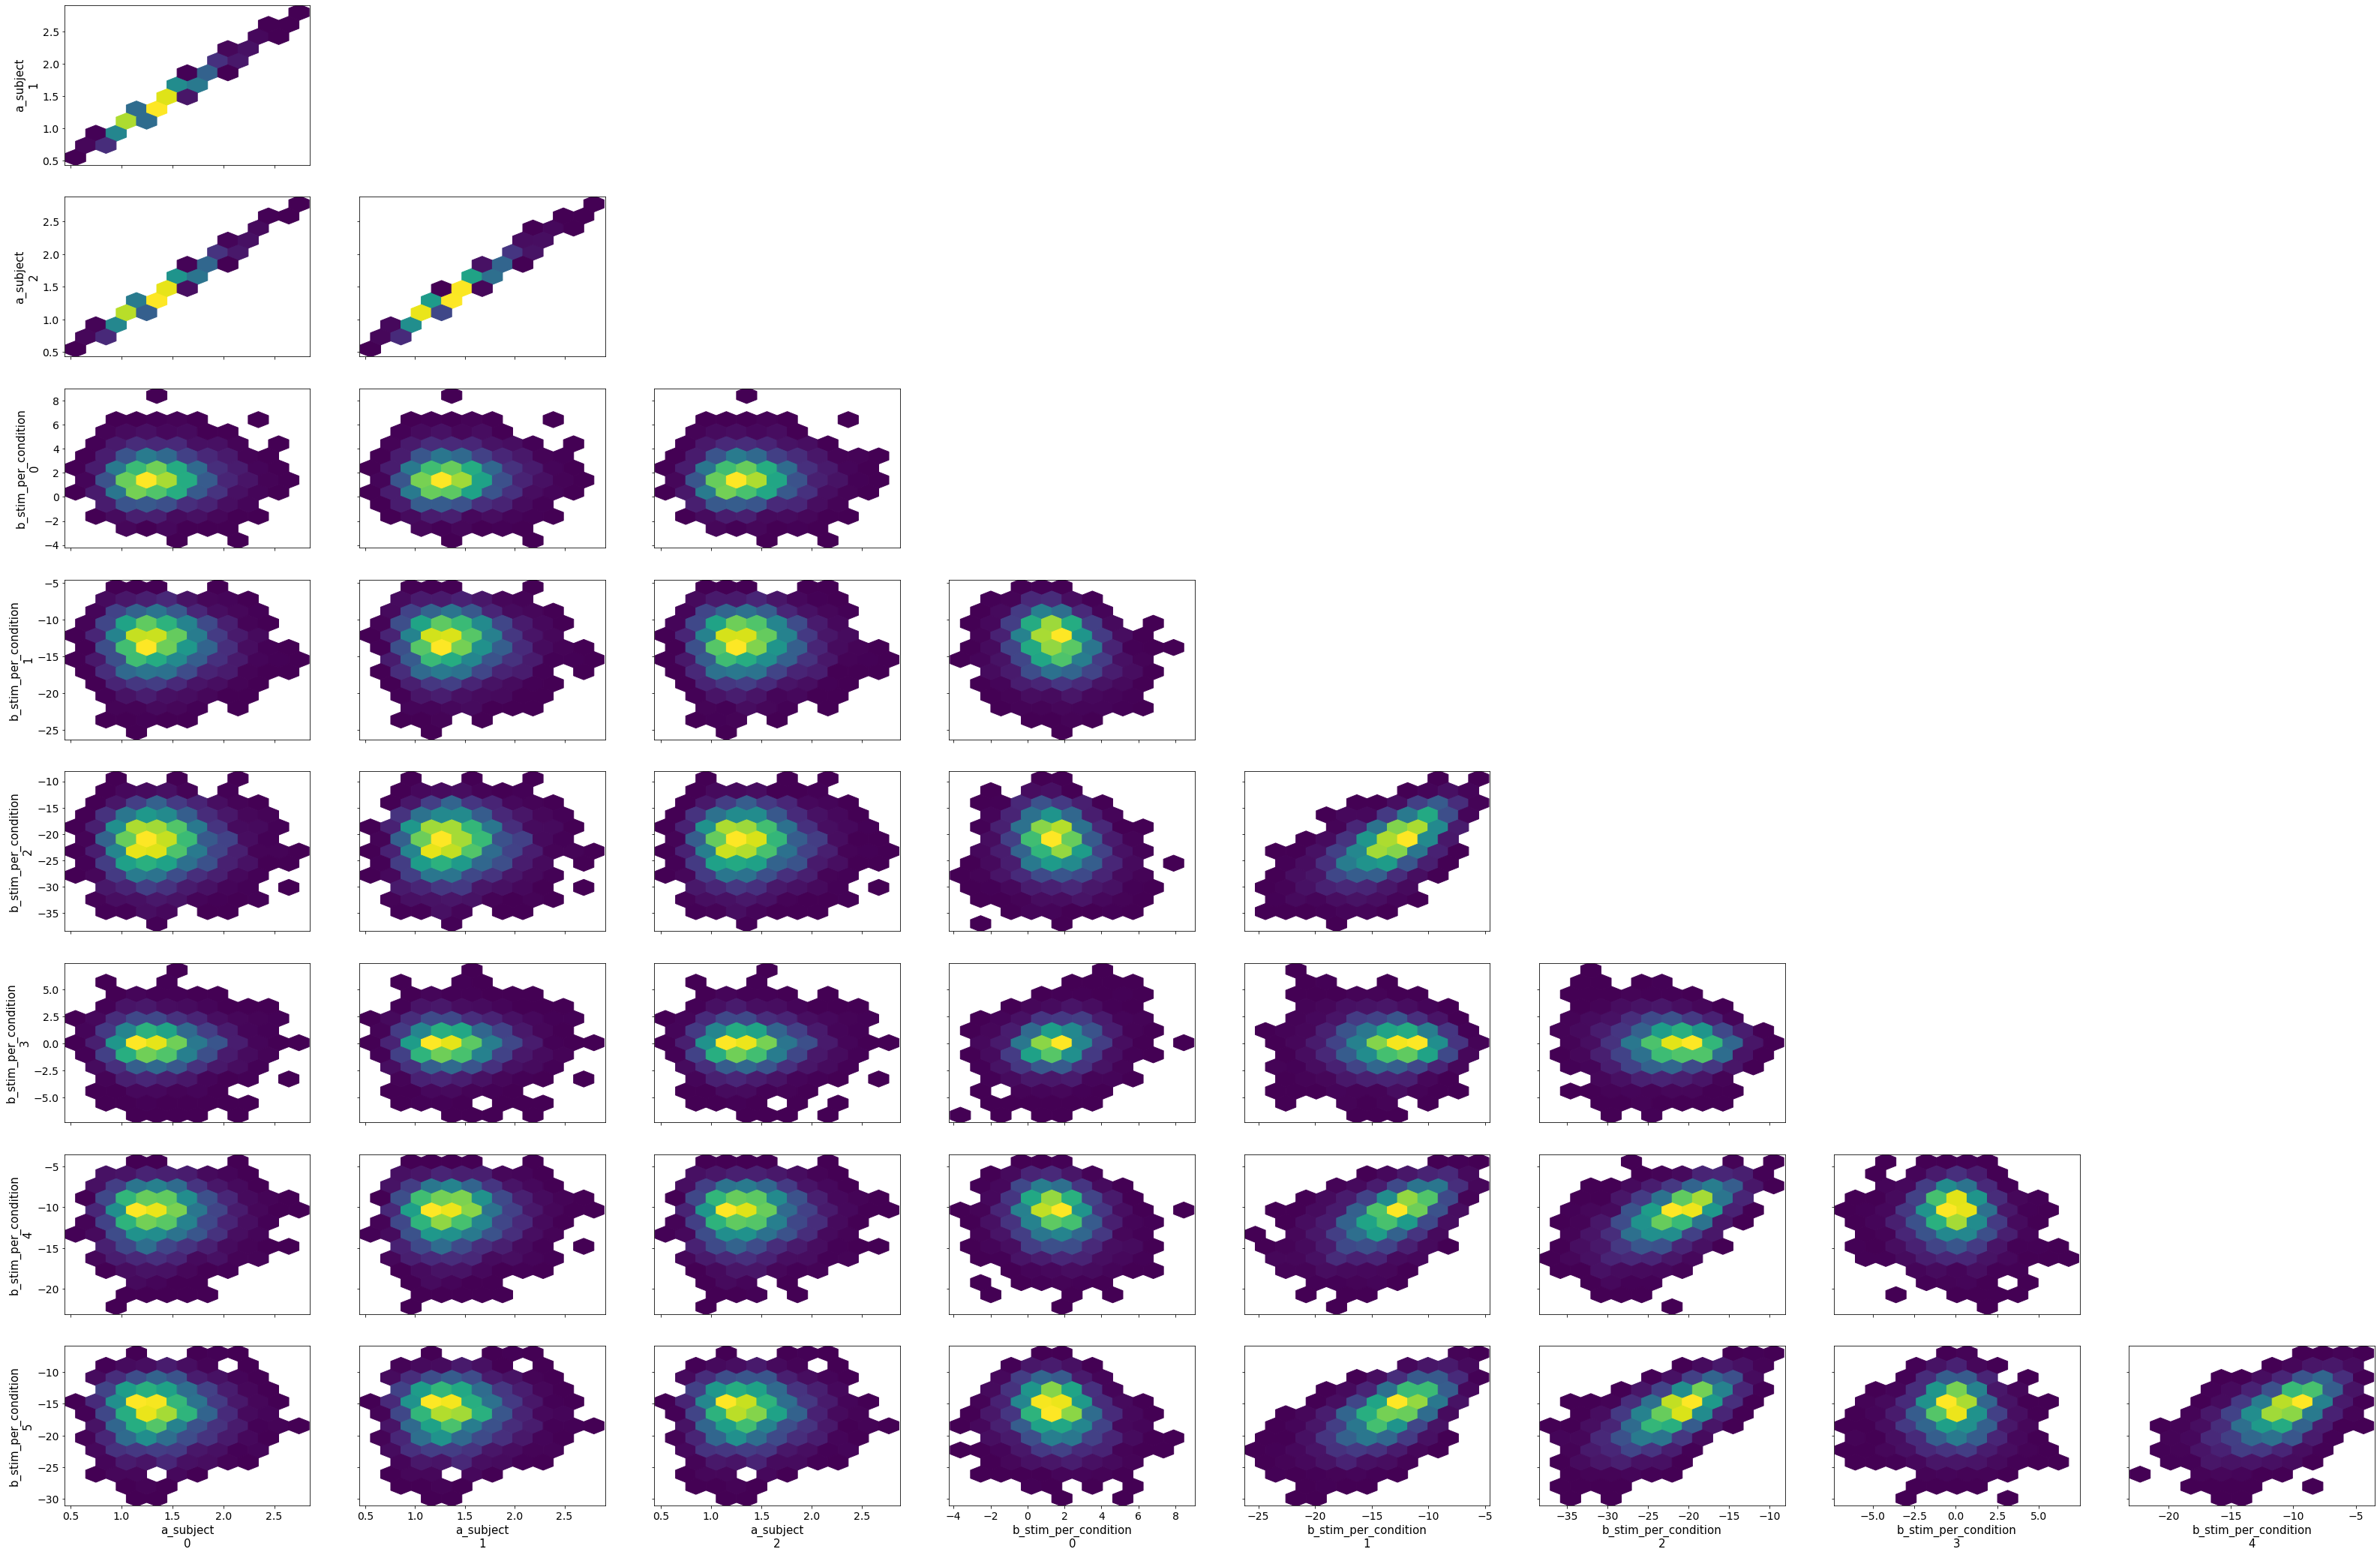

In [37]:
# Gamma GLM intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=True,
              add_group_slope=False, 
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

group slopes+ group intercepts=>divergences

## LME fails

In [6]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=False)

Using formula isi ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.080    0.016    5.063  0.000   0.049   0.111
1 | mouse                  -0.007    0.008   -0.885  0.376  -0.024   0.009
stim | neuron_x_mouse__0    0.005    0.002    2.203  0.028   0.001   0.010
stim | neuron_x_mouse__1   -0.007    0.002   -2.934  0.003  -0.012  -0.002
stim | neuron_x_mouse__2   -0.010    0.002   -4.056  0.000  -0.015  -0.005
stim | neuron_x_mouse__3   -0.022    0.002   -8.842  0.000  -

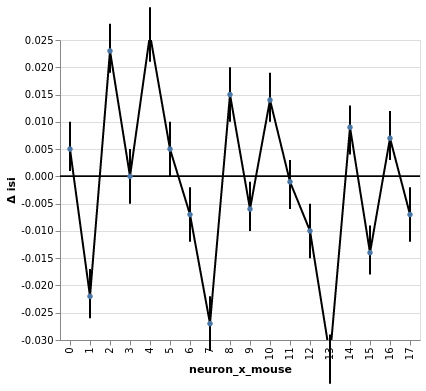

'Proper faceting will work when data addition is implemented in fit_lme()'

In [7]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O').display()
#bw.facet(column='mouse').display()
"Proper faceting will work when data addition is implemented in fit_lme()"

In [8]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True)

Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.075    0.011    6.738  0.000   0.053   0.097
stim | mouse               -0.007    0.008   -0.885  0.376  -0.024   0.009
stim | neuron_x_mouse__0    0.003    0.003    0.932  0.351  -0.004   0.010
stim | neuron_x_mouse__1   -0.009    0.003   -2.688  0.007  -0.016  -0.003
stim | neuron_x_mouse__2   -0.012    0.003   -3.480  0.001  -0.019  -0.005
stim | neuron_x_mouse__3   -0.024    0.003   -6.853  0.000

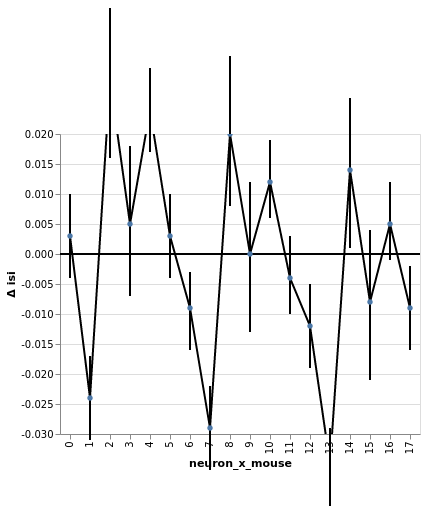

In [9]:
bw.plot_posteriors_slopes(x='neuron_x_mouse:O').display()

Need nested design, but get singular matrix:

In [10]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
try:
    bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True, add_nested_group=True)
except Exception as e:
    print(e)
        


Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0:mouse + stim|neuron_x_mouse__1:mouse + stim|neuron_x_mouse__2:mouse + stim|neuron_x_mouse__3:mouse + stim|neuron_x_mouse__4:mouse + stim|neuron_x_mouse__5:mouse + stim|neuron_x_mouse__6:mouse + stim|neuron_x_mouse__7:mouse + stim|neuron_x_mouse__8:mouse + stim|neuron_x_mouse__9:mouse + stim|neuron_x_mouse__10:mouse + stim|neuron_x_mouse__11:mouse + stim|neuron_x_mouse__12:mouse + stim|neuron_x_mouse__13:mouse + stim|neuron_x_mouse__14:mouse + stim|neuron_x_mouse__15:mouse + stim|neuron_x_mouse__16:mouse + stim|neuron_x_mouse__17:mouse
Singular matrix
